# Installs & Imports

In [1]:
!pip install -q pytorch-lightning pytorch-forecasting pytorch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.9/221.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 52.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import requests
from io import BytesIO
import warnings
import re

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import (
    Baseline,
    TemporalFusionTransformer,
    TimeSeriesDataSet
)
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, SMAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

SEED = 42
pl.seed_everything(SEED)
torch.set_float32_matmul_precision('medium')

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [3]:
def ignore_specific_warnings():
    """Ignore specific warnings."""
    # Ignore feature name warnings
    warnings.filterwarnings("ignore", message="X does not have valid feature names")

    # Ignore PyTorch Lightning checkpointing warnings
    warnings.filterwarnings(
        action="ignore",
        message=re.escape(
            "Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. "
            "It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`."
        ),
        category=UserWarning
    )
    warnings.filterwarnings(
        action="ignore",
        message=re.escape(
            "Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. "
            "It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`."
        ),
        category=UserWarning
    )

    # DataLoader worker warnings
    warnings.filterwarnings(
        action="ignore",
        message=r"The '(train|val)_dataloader' does not have many workers which may be a bottleneck\. "
                r"Consider increasing the value of the `num_workers` argument` to `num_workers=\d+` "
                r"in the `DataLoader` to improve performance\.",
        category=UserWarning
    )

# Data Loading

In [4]:
def download_and_extract_jena_climate_data():
    url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
    response = requests.get(url)

    with ZipFile(BytesIO(response.content)) as thezip:
        csv_file = [f for f in thezip.namelist() if f.endswith('.csv')][0]
        with thezip.open(csv_file) as thefile:
            data = pd.read_csv(thefile)

    # Systematic cleaning of column names (replace punctuation, etc.)
    data.columns = (
        data.columns
        .str.replace(r"[\\.,()]", "_", regex=True)
        .str.replace("/", "_")
        .str.replace(" ", "_")
        .str.replace("__+", "_", regex=True)
        .str.strip("_")
        .str.lower()
    )

    # Rename certain columns for consistency
    data = data.rename(columns={
        "max_wv_m_s": "max_wind_velocity",
        "rho_g_m**3": "air_density",
        "rh_%": "rh_percent"
    })
    return data

df_raw = download_and_extract_jena_climate_data()
print("Raw data shape:", df_raw.shape)
df_raw.head()

Raw data shape: (420451, 15)


,date_time,p_mbar,t_degc,tpot_k,tdew_degc,rh_percent,vpmax_mbar,vpact_mbar,vpdef_mbar,sh_g_kg,h2oc_mmol_mol,air_density,wv_m_s,max_wind_velocity,wd_deg
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
def aggregate_daily_and_convert_to_fahrenheit(df):
    # Convert to datetime with the correct format
    df["date_time"] = pd.to_datetime(df["date_time"], format="%d.%m.%Y %H:%M:%S")

    # Set index for resample
    df.set_index("date_time", inplace=True)

    # Resample daily, taking mean for all columns
    daily_df = df.resample("D").mean()

    # Fill any missing daily rows
    daily_df = daily_df.ffill().bfill()

    # Reset index
    daily_df.reset_index(inplace=True)

    # Convert Celsius to Fahrenheit
    daily_df["t_fahr"] = daily_df["t_degc"] * 9/5 + 32

    return daily_df

df_daily = aggregate_daily_and_convert_to_fahrenheit(df_raw)
print("Daily data shape:", df_daily.shape)
df_daily.head()

Daily data shape: (2923, 16)


,date_time,p_mbar,t_degc,tpot_k,tdew_degc,rh_percent,vpmax_mbar,vpact_mbar,vpdef_mbar,sh_g_kg,h2oc_mmol_mol,air_density,wv_m_s,max_wind_velocity,wd_deg,t_fahr
0,2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,3.357832,1305.178252,0.778601,1.378252,181.863077,19.740867
1,2009-01-02,999.600625,-3.728194,269.463194,-4.824861,92.086806,4.640069,4.267292,0.373056,2.659792,4.268750,1290.353194,1.419514,2.227361,125.072014,25.289250
2,2009-01-03,998.548611,-5.271736,268.002292,-9.015833,76.458056,4.184792,3.107708,1.077014,1.937778,3.111944,1297.117014,1.250903,2.065069,190.383333,22.510875
3,2009-01-04,988.510694,-1.375208,272.685347,-2.897014,89.417361,5.524306,4.938958,0.584861,3.114028,4.997014,1264.634514,1.720417,3.564861,213.069861,29.524625
4,2009-01-05,990.405694,-4.867153,269.039306,-6.797292,86.260417,4.362708,3.806736,0.555625,2.397014,3.847778,1284.372778,3.800278,5.940000,118.287361,23.239125


# Data Exploration

Dataset Shape: (2923, 16)

Columns: ['date_time', 'p_mbar', 't_degc', 'tpot_k', 'tdew_degc', 'rh_percent', 'vpmax_mbar', 'vpact_mbar', 'vpdef_mbar', 'sh_g_kg', 'h2oc_mmol_mol', 'air_density', 'wv_m_s', 'max_wind_velocity', 'wd_deg', 't_fahr']

Missing Values:
 date_time            0
p_mbar               0
t_degc               0
tpot_k               0
tdew_degc            0
rh_percent           0
vpmax_mbar           0
vpact_mbar           0
vpdef_mbar           0
sh_g_kg              0
h2oc_mmol_mol        0
air_density          0
wv_m_s               0
max_wind_velocity    0
wd_deg               0
t_fahr               0
dtype: int64

Infinite Values:
 p_mbar               0
t_degc               0
tpot_k               0
tdew_degc            0
rh_percent           0
vpmax_mbar           0
vpact_mbar           0
vpdef_mbar           0
sh_g_kg              0
h2oc_mmol_mol        0
air_density          0
wv_m_s               0
max_wind_velocity    0
wd_deg               0
t_fahr           

,date_time,p_mbar,t_degc,tpot_k,tdew_degc,rh_percent,vpmax_mbar,vpact_mbar,vpdef_mbar,sh_g_kg,h2oc_mmol_mol,air_density,wv_m_s,max_wind_velocity,wd_deg,t_fahr
count,2923,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000
mean,2013-01-01 00:00:00,989.222002,9.438230,283.480047,4.952836,76.046342,13.564189,9.531887,4.032217,6.021178,9.638264,1216.125458,2.127686,3.528523,174.758497,48.988813
min,2009-01-01 00:00:00,948.995972,-16.457292,256.104028,-19.387222,37.580347,1.701597,1.312917,0.000000,0.810625,1.302014,1134.728472,0.000000,0.000000,0.000000,2.376875
25%,2011-01-01 12:00:00,984.362674,3.811007,277.825556,0.364028,67.675382,8.096806,6.301354,1.338507,3.983056,6.388125,1188.102813,1.448958,2.494271,142.322083,38.859812
50%,2013-01-01 00:00:00,989.530000,9.704722,283.839236,5.288611,76.999792,12.247292,8.938056,2.973264,5.626528,9.014861,1212.220069,1.902986,3.229931,188.554167,49.468500
75%,2015-01-01 12:00:00,994.432396,15.433333,289.493368,9.952569,84.577604,17.953299,12.307778,5.689271,7.764340,12.424028,1240.976806,2.586701,4.252014,212.442326,59.780000
max,2017-01-01 00:00:00,1013.957569,29.375347,303.124097,20.185486,100.000000,43.083403,23.749722,24.012778,15.101667,24.056806,1367.595417,7.644514,11.465208,279.445139,84.875625
std,NaN,8.093072,7.837663,7.899685,6.581972,11.389098,6.876650,4.074084,3.548557,2.585312,4.122727,37.376821,0.969502,1.480909,54.384671,14.107794


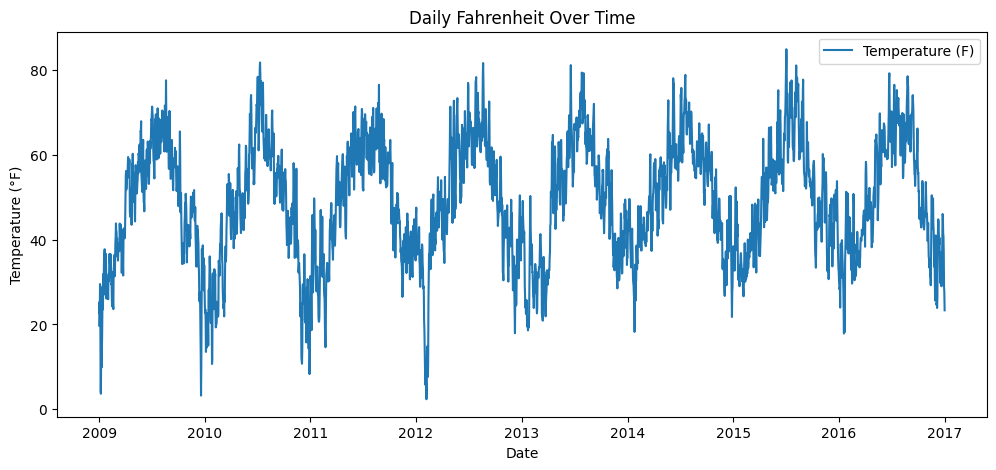

In [6]:
def explore_dataset(df):
    print("Dataset Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nMissing Values:\n", df.isnull().sum())

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_counts = (np.isinf(df[numeric_cols])).sum()
    print("\nInfinite Values:\n", inf_counts)

    # Show stats
    print("\n")
    display(df.describe())
    print("\n")

    # Plot the new Fahrenheit column over time
    plt.figure(figsize=(12, 5))
    plt.plot(df["date_time"], df["t_fahr"], label="Temperature (F)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°F)")
    plt.title("Daily Fahrenheit Over Time")
    plt.legend()
    plt.show()

explore_dataset(df_daily)

# Feature Engineering

In [7]:
def feature_engineering(df):
    df = df.copy()
    df.sort_values("date_time", inplace=True, ignore_index=True)

    # Create a consecutive daily index
    df["time_idx"] = (df["date_time"] - df["date_time"].min()).dt.days

    # cyclical features for day_of_year
    df["day_of_year"] = df["date_time"].dt.dayofyear
    df["day_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
    df["day_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)

    # single time series
    df["group_id"] = 0

    return df

df_feat = feature_engineering(df_daily)
df_feat.head()

,date_time,p_mbar,t_degc,tpot_k,tdew_degc,rh_percent,vpmax_mbar,vpact_mbar,vpdef_mbar,sh_g_kg,...,air_density,wv_m_s,max_wind_velocity,wd_deg,t_fahr,time_idx,day_of_year,day_sin,day_cos,group_id
0,2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,...,1305.178252,0.778601,1.378252,181.863077,19.740867,0,1,0.017202,0.999852,0
1,2009-01-02,999.600625,-3.728194,269.463194,-4.824861,92.086806,4.640069,4.267292,0.373056,2.659792,...,1290.353194,1.419514,2.227361,125.072014,25.289250,1,2,0.034398,0.999408,0
2,2009-01-03,998.548611,-5.271736,268.002292,-9.015833,76.458056,4.184792,3.107708,1.077014,1.937778,...,1297.117014,1.250903,2.065069,190.383333,22.510875,2,3,0.051584,0.998669,0
3,2009-01-04,988.510694,-1.375208,272.685347,-2.897014,89.417361,5.524306,4.938958,0.584861,3.114028,...,1264.634514,1.720417,3.564861,213.069861,29.524625,3,4,0.068755,0.997634,0
4,2009-01-05,990.405694,-4.867153,269.039306,-6.797292,86.260417,4.362708,3.806736,0.555625,2.397014,...,1284.372778,3.800278,5.940000,118.287361,23.239125,4,5,0.085906,0.996303,0


# Data Splitting

In [8]:
def temporal_split(df, ratios=(0.7, 0.15)):
    df = df.sort_values("time_idx")
    n = len(df)
    end_train = int(n * ratios[0])
    end_val   = int(n * (ratios[0] + ratios[1]))

    train_df = df.iloc[:end_train].copy()
    val_df   = df.iloc[end_train:end_val].copy()
    test_df  = df.iloc[end_val:].copy()

    return train_df, val_df, test_df

train_df, val_df, test_df = temporal_split(df_feat, ratios=(0.7, 0.15))

print(f"Train: {len(train_df)} rows")
print(f"Val:   {len(val_df)} rows")
print(f"Test:  {len(test_df)} rows")

# Quick checks for missing target in each subset
print("\nTrain NA t_fahr:", train_df["t_fahr"].isna().sum())
print("Val NA t_fahr:  ", val_df["t_fahr"].isna().sum())
print("Test NA t_fahr: ", test_df["t_fahr"].isna().sum())

Train: 2046 rows
Val:   438 rows
Test:  439 rows

Train NA t_fahr: 0
Val NA t_fahr:   0
Test NA t_fahr:  0


# TimeSeriesDataset Creation

In [9]:
def create_tsdataset(data, max_encoder_length=30, max_prediction_length=6):
    return TimeSeriesDataSet(
        data=data,
        time_idx="time_idx",
        target="t_fahr",
        group_ids=["group_id"],
        static_categoricals=[],
        time_varying_known_reals=["time_idx", "day_sin", "day_cos"],
        time_varying_unknown_reals=[
            "t_fahr",
            "p_mbar",
            "rh_percent",
            "max_wind_velocity",
            "air_density"
        ],
        min_prediction_length=1,
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        add_relative_time_idx=True,
        add_target_scales=True,
        allow_missing_timesteps=True,
    )

In [10]:
# Create TimeSeriesDataSet objects
train_ds = create_tsdataset(
    train_df,
    max_prediction_length=6
)
val_ds = TimeSeriesDataSet.from_dataset(
    train_ds,
    val_df,
    predict=True,
    stop_randomization=True
)
test_ds = TimeSeriesDataSet.from_dataset(
    train_ds,
    test_df,
    predict=True,
    stop_randomization=True
)

print("Train dataset parameters:")
print(train_ds.get_parameters())
print(len(train_ds.decoded_index))

Train dataset parameters:
{'time_idx': 'time_idx', 'target': 't_fahr', 'group_ids': ['group_id'], 'weight': None, 'max_encoder_length': 30, 'min_encoder_length': 30, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 6, 'static_categoricals': [], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx', 'day_sin', 'day_cos'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['t_fahr', 'p_mbar', 'rh_percent', 'max_wind_velocity', 'air_density'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': False, 'target_normalizer': EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
), 'categorical_encoders': {'__group_id__group_id': NaNLabelEncoder(add_nan=False, warn=True)}, 'scalers': {'t_fahr_center': Stan

# DataLoader Creation

In [11]:
def create_dataloaders(train_ds, val_ds, test_ds, batch_size=16):
    train_loader = train_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=7, shuffle=True, drop_last=True)
    val_loader   = val_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=7, shuffle=False, drop_last=False)
    test_loader  = test_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=7, shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader

In [12]:
ignore_specific_warnings()

# Create DataLoaders
train_dl, val_dl, test_dl = create_dataloaders(
    train_ds,
    val_ds,
    test_ds,
    batch_size=16
)
print("Train Loader Batches:", len(train_dl))
print("Val Loader Batches:  ", len(val_dl))
print("Test Loader Batches: ", len(test_dl))

# Quick sample batch check
batch_sample = next(iter(train_dl))
print("\nSample Batch Keys:", batch_sample[0].keys())

Train Loader Batches: 126
Val Loader Batches:   1
Test Loader Batches:  1

Sample Batch Keys: dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])


# Model Definition

In [13]:
def create_model(
    train_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    optimizer="adam",
    reduce_on_plateau_patience=4,
    log_interval=10,
    quantiles=None
):
    """
    Creates a TemporalFusionTransformer from the given training TimeSeriesDataSet.

    Args:
        train_dataset (TimeSeriesDataSet): training dataset from which model params are inferred
        learning_rate (float): initial learning rate
        hidden_size (int): size of network hidden layers
        attention_head_size (int): number of attention heads
        dropout (float): dropout probability
        hidden_continuous_size (int): size of hidden layers for continuous variables
        optimizer (str): optimizer to use
        reduce_on_plateau_patience (int): reduce LR if plateau for these many epochs
        quantiles (list): list of quantiles to predict

    Returns:
        TemporalFusionTransformer model
    """
    if quantiles is None:
        quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    output_size = len(quantiles)

    model = TemporalFusionTransformer.from_dataset(
        train_dataset,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        output_size=output_size,
        loss=QuantileLoss(quantiles=quantiles),
        log_interval=log_interval,
        optimizer=optimizer,
        reduce_on_plateau_patience=reduce_on_plateau_patience,
    )
    return model

# Model Training

In [14]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer

In [15]:
def setup_callbacks_and_logger():
    """
    Sets up callbacks and logger for the PyTorch Lightning Trainer.

    Returns:
        callbacks (list): List of callbacks.
        logger (TensorBoardLogger): Configured logger.
    """
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=True,
        mode="min"
    )

    lr_logger = LearningRateMonitor(logging_interval='epoch')

    # TensorBoard logger
    logger = TensorBoardLogger(
        save_dir=os.getcwd(),
        version=1,
        name="tft_logs"
    )
    return [lr_logger, early_stop_callback], logger

In [16]:
# Prepare callbacks, logger, and trainer
callbacks, logger = setup_callbacks_and_logger()

In [17]:
def initialize_trainer(callbacks, logger, max_epochs=50):
    """
    Initializes the PyTorch Lightning Trainer.

    Args:
        callbacks (list): List of callbacks.
        logger (TensorBoardLogger): Logger.
        max_epochs (int): Maximum number of epochs.

    Returns:
        trainer (Trainer): The initialized trainer.
    """
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        enable_model_summary=True,
        gradient_clip_val=0.1,
        callbacks=callbacks,
        logger=logger,
        deterministic=False,
    )
    return trainer

In [18]:
# Initialize the trainer
trainer = initialize_trainer(callbacks, logger, max_epochs=50)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
def train_model(trainer, model, train_dataloader, val_dataloader, save_path):
    """
    Trains the given model using the provided trainer and dataloaders.

    Args:
        trainer (Trainer): The PyTorch Lightning trainer.
        model (TemporalFusionTransformer): The model to train.
        train_dataloader (DataLoader): The training dataloader.
        val_dataloader (DataLoader): The validation dataloader.
        save_path (str): Path to save the trained model.

    Returns:
        None
    """
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # Save checkpoint
    trainer.save_checkpoint(save_path)
    print(f"Model checkpoint saved to {save_path}")

In [20]:
# Create the model
tft_model = create_model(
    train_ds,
    quantiles=[0.1, 0.3, 0.5, 0.7, 0.9]
)

In [21]:
ignore_specific_warnings()

# Train the model
train_model(
    trainer,
    tft_model,
    train_dl,
    val_dl,
    save_path="./trained_model.ckpt"
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 176    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.9 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.4 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 3.589
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 3.589


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.318 >= min_delta = 0.0001. New best score: 2.271
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.318 >= min_delta = 0.0001. New best score: 2.271


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.519 >= min_delta = 0.0001. New best score: 1.751
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.519 >= min_delta = 0.0001. New best score: 1.751


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 1.751. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 1.751. Signaling Trainer to stop.


Model checkpoint saved to ./trained_model.ckpt


In [22]:
# Load the model from the save path
tft_loaded = TemporalFusionTransformer.load_from_checkpoint(
    "./trained_model.ckpt"
)

# Model Evaluation

In [23]:
# Load the best model
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Best model path: /content/tft_logs/version_1/checkpoints/epoch=12-step=1638.ckpt


In [24]:
# Verify dataset parameters
print("Test Dataset - Encoder length:", test_dl.dataset.max_encoder_length)
print("Test Dataset - Prediction length:", test_dl.dataset.max_prediction_length)

# Verify model was trained with matching parameters
print("\nModel's training dataset configuration:")
print("Max encoder length:", best_tft.dataset_parameters["max_encoder_length"])
print("Max prediction length:", best_tft.dataset_parameters["max_prediction_length"])

Test Dataset - Encoder length: 30
Test Dataset - Prediction length: 6

Model's training dataset configuration:
Max encoder length: 30
Max prediction length: 6


In [25]:
# Get predictions
predictions = best_tft.predict(
    test_dl,
    return_y=True,
    return_x=True,
    trainer_kwargs=dict(accelerator="gpu", devices=1)
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [26]:
# Metrics
rmse = RMSE()(predictions.output, predictions.y)
mae = MAE()(predictions.output, predictions.y)
mape = MAPE()(predictions.output, predictions.y)
smape = SMAPE()(predictions.output, predictions.y)

rmse_item = rmse.item()
mae_item = mae.item()
mape_item = mape.item()
smape_item = smape.item()

print("RMSE:", rmse_item)
print("MAE:", mae_item)
print("MAPE:", mape_item)
print("SMAPE:", smape_item)

RMSE: 12.368898391723633
MAE: 10.926526069641113
MAPE: 0.3848564624786377
SMAPE: 0.3019726574420929


In [27]:
# Create metrics DataFrame
metrics_df = pd.DataFrame({
    "RMSE": [rmse_item],
    "MAE": [mae_item],
    "MAPE": [mape_item],
    "SMAPE": [smape_item]
}).T
metrics_df.columns = ["Score"]

display(metrics_df)

,Score
RMSE,12.368898
MAE,10.926526
MAPE,0.384856
SMAPE,0.301973


In [28]:
# Convert MAPE and SMAPE to percentages and rename metrics
metrics_df.loc["MAPE", "Score"] *= 100
metrics_df.loc["SMAPE", "Score"] *= 100
metrics_df = metrics_df.rename(index={
    "MAPE": "MAPE(%)",
    "SMAPE": "SMAPE(%)"
}).round(3)

display(metrics_df)

,Score
RMSE,12.369
MAE,10.927
MAPE(%),38.486
SMAPE(%),30.197


In [29]:
def plot_metrics_barplot(
    df,
    title='Model Performance Metrics',
    xlabel='Metric',
    ylabel='Value',
    figsize=(10, 6),
    colors=None,
    fontsize=9,
    label_format='{value:.2f}',
    y_offset=0.1
):
    """Creates a bar plot for model evaluation metrics."""
    fig, ax = plt.subplots(figsize=figsize)

    # Use color scheme if not specified
    n_metrics = len(df)
    if colors is None:
        colors = plt.cm.Set2.colors[:n_metrics]

    # Plot bars with individual colors
    bars = ax.bar(df.index, df['Score'], color=colors)

    # Customize plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=0)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + y_offset,
                label_format.format(value=height),
                ha='center', va='bottom', fontsize=fontsize)

    plt.tight_layout()
    plt.show()

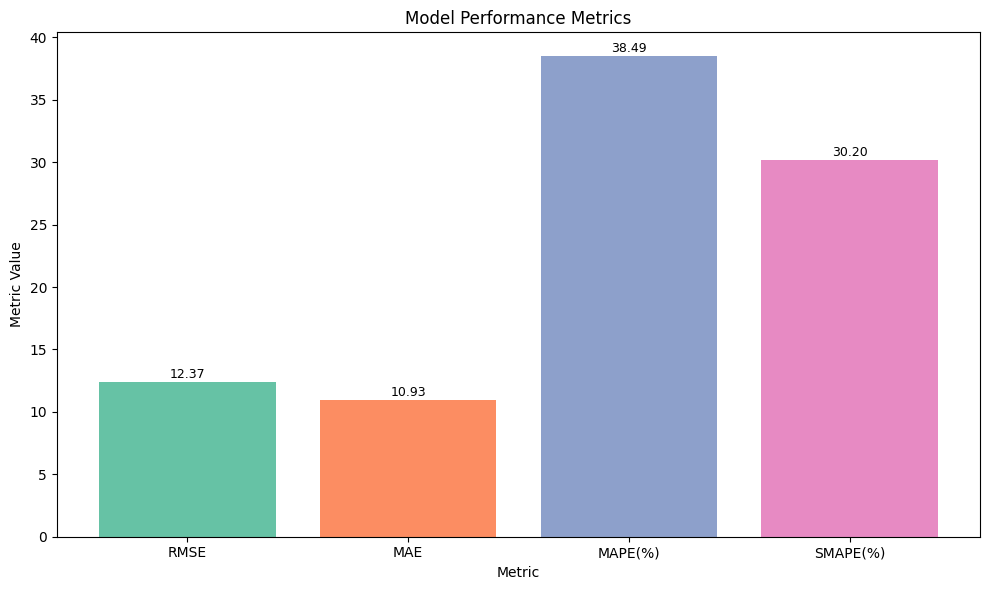

In [30]:
# Plot the metrics
plot_metrics_barplot(
    metrics_df,
    title='Model Performance Metrics',
    ylabel='Metric Value'
)

In [31]:
# Raw predictions
raw_predictions = best_tft.predict(
    test_dl,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="gpu")
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x425 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

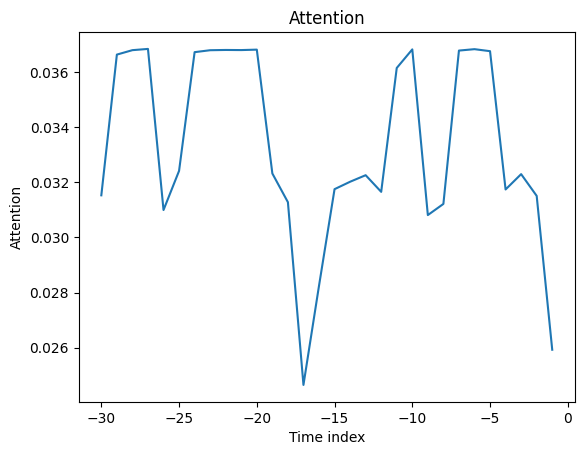

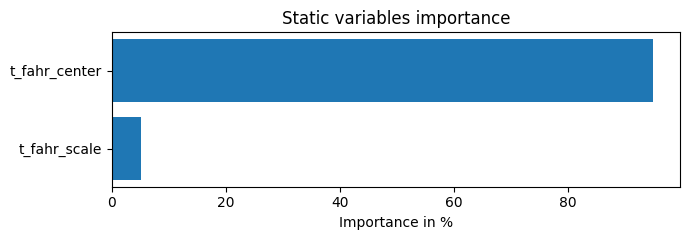

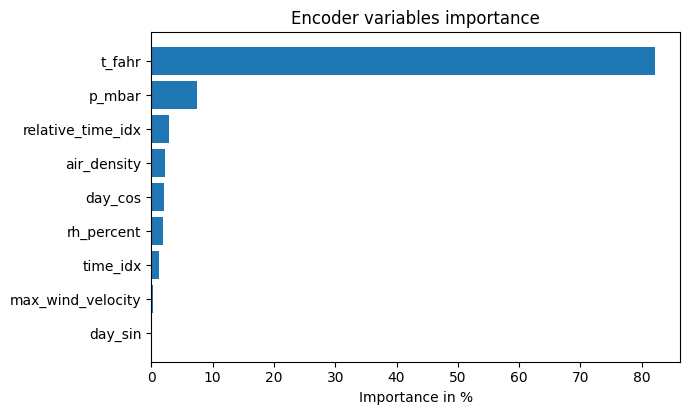

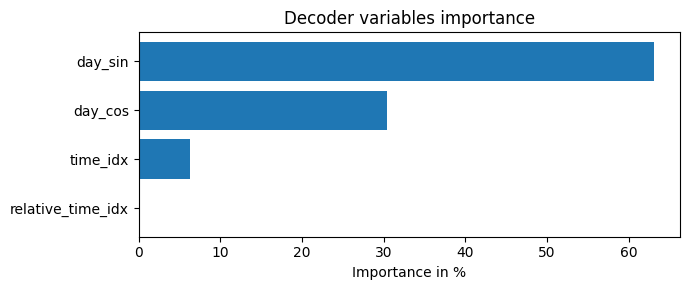

In [32]:
# Interpretation
interpretation = best_tft.interpret_output(
    raw_predictions.output,
    reduction="sum"
)
best_tft.plot_interpretation(interpretation)

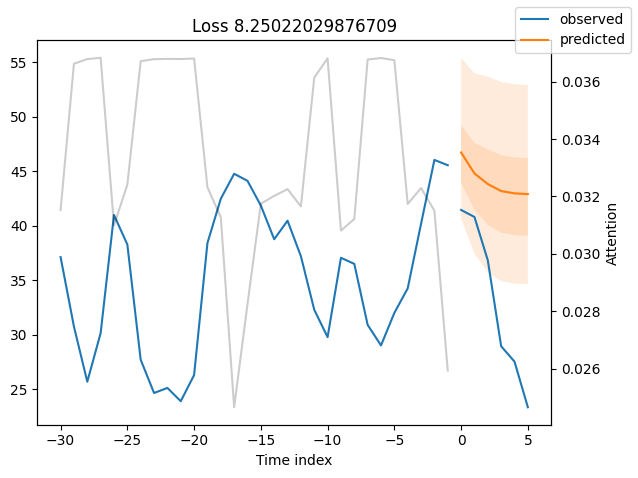

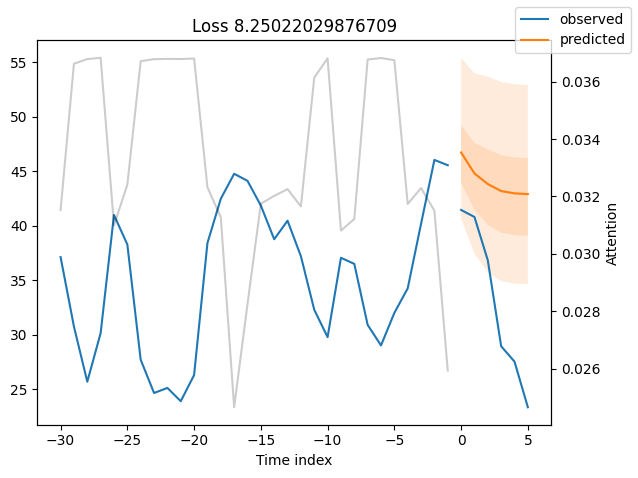

In [33]:
# Plot predictions
best_tft.plot_prediction(
    raw_predictions.x,
    raw_predictions.output,
    idx=0,
    add_loss_to_title=True
)

{'t_fahr_center': <Figure size 1000x500 with 2 Axes>,
 't_fahr_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'day_sin': <Figure size 1000x500 with 2 Axes>,
 'day_cos': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 't_fahr': <Figure size 1000x500 with 2 Axes>,
 'p_mbar': <Figure size 1000x500 with 2 Axes>,
 'rh_percent': <Figure size 1000x500 with 2 Axes>,
 'max_wind_velocity': <Figure size 1000x500 with 2 Axes>,
 'air_density': <Figure size 1000x500 with 2 Axes>}

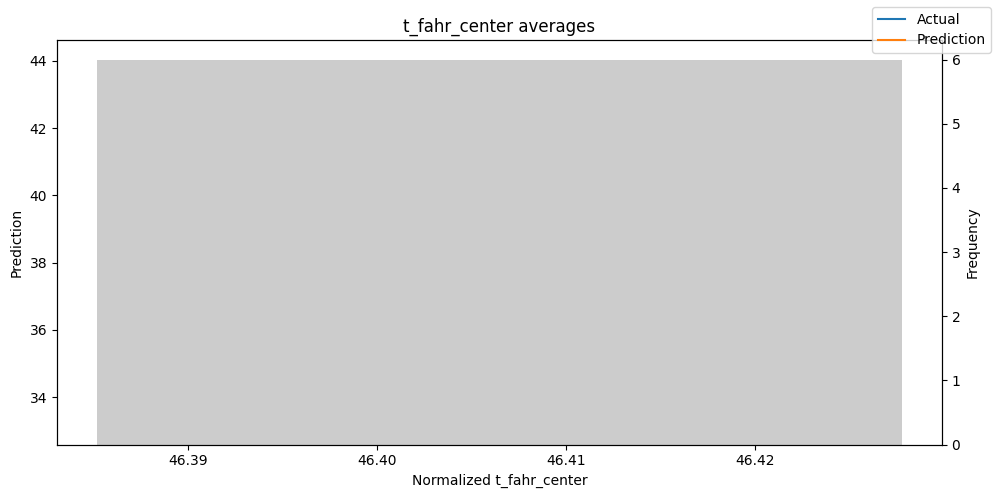

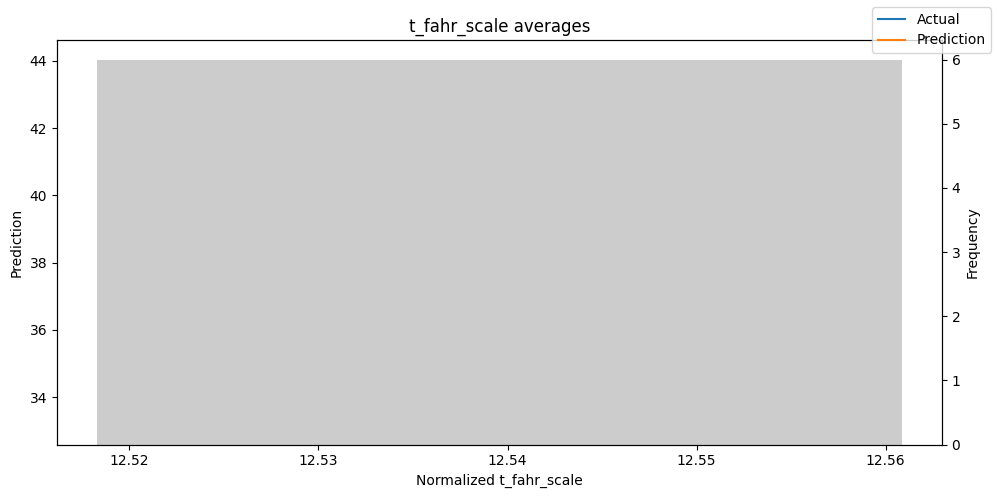

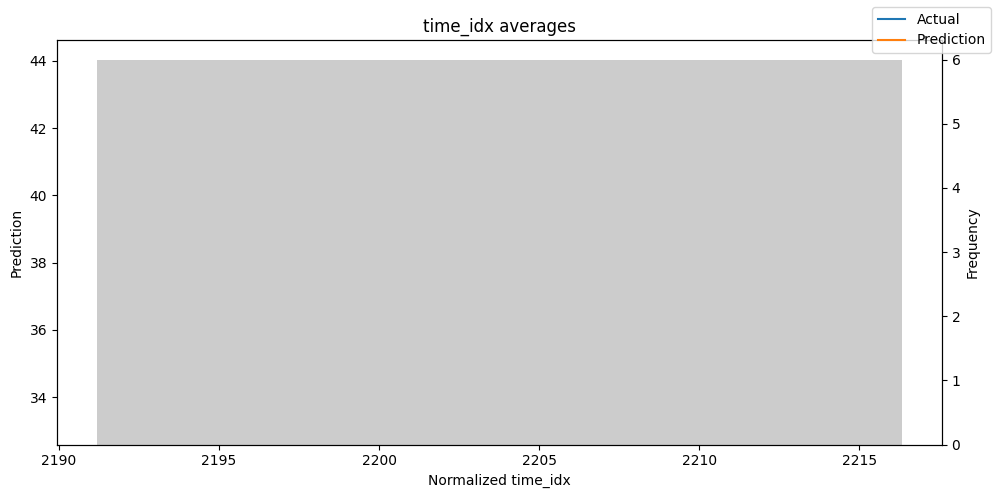

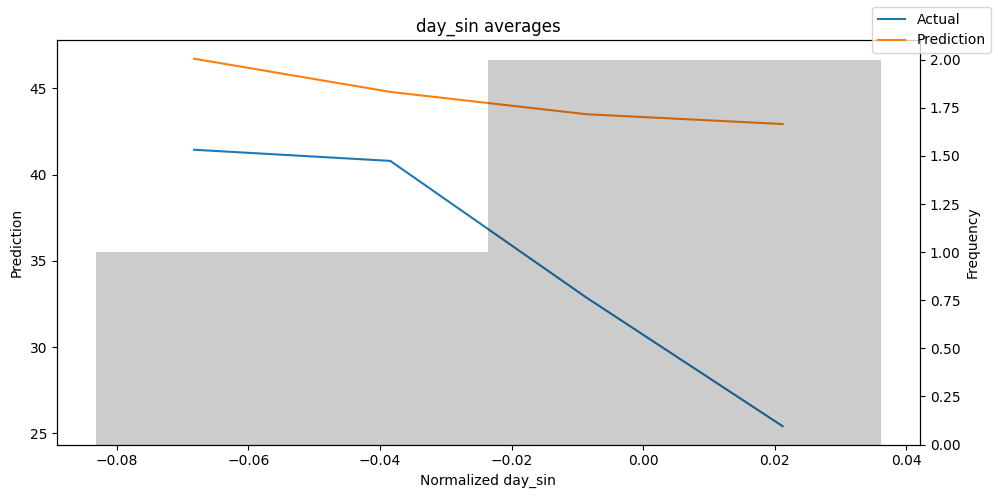

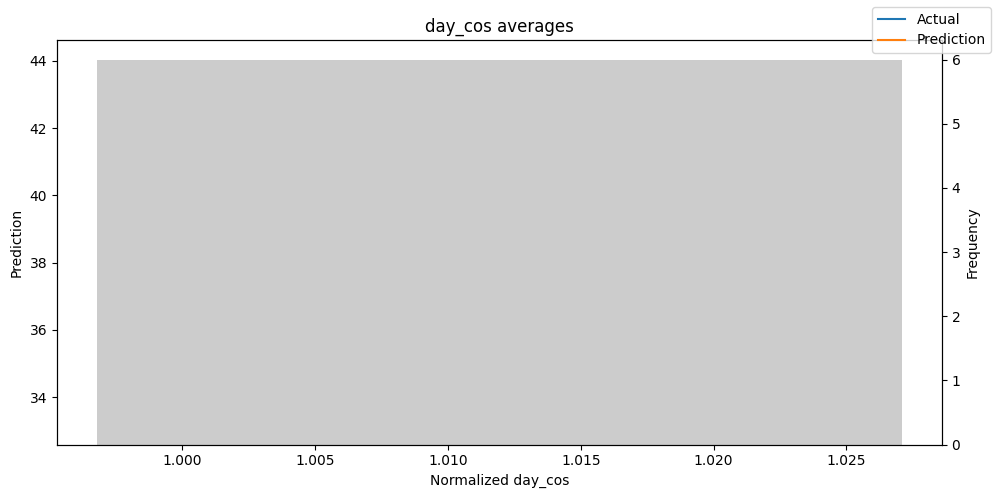

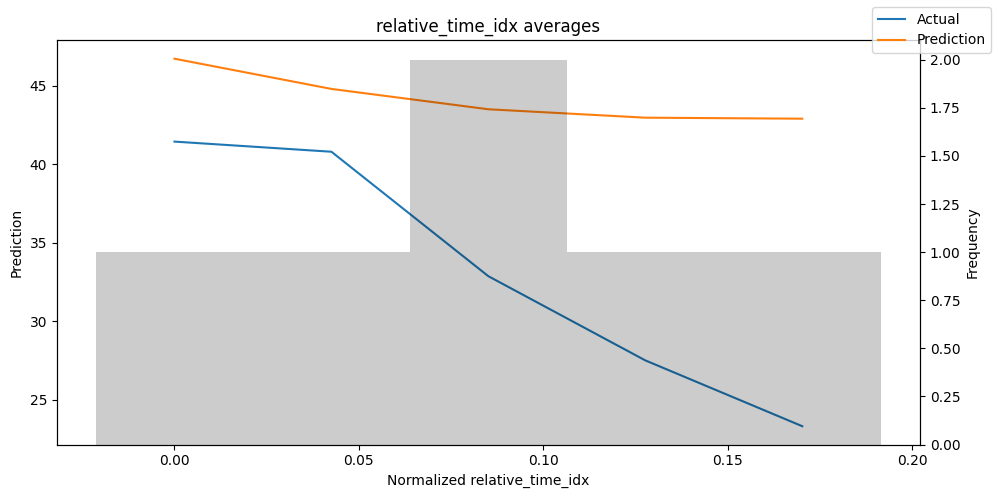

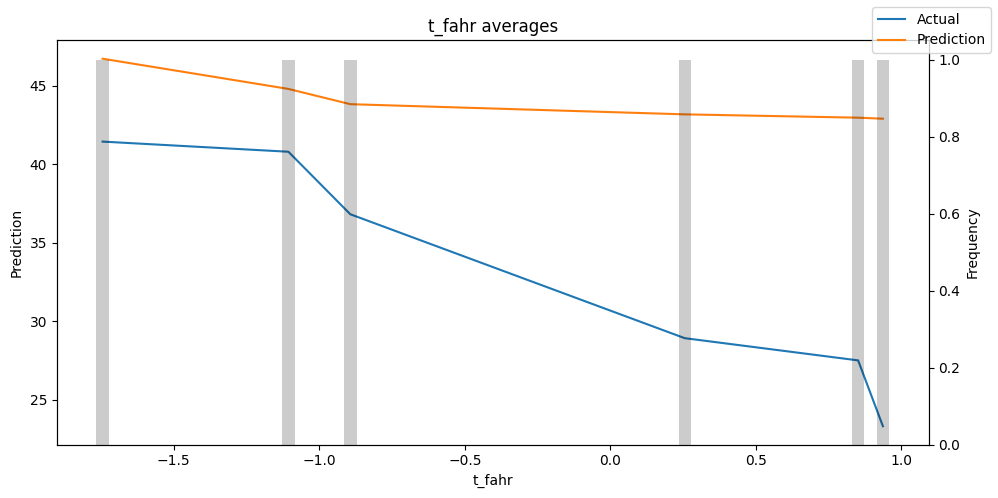

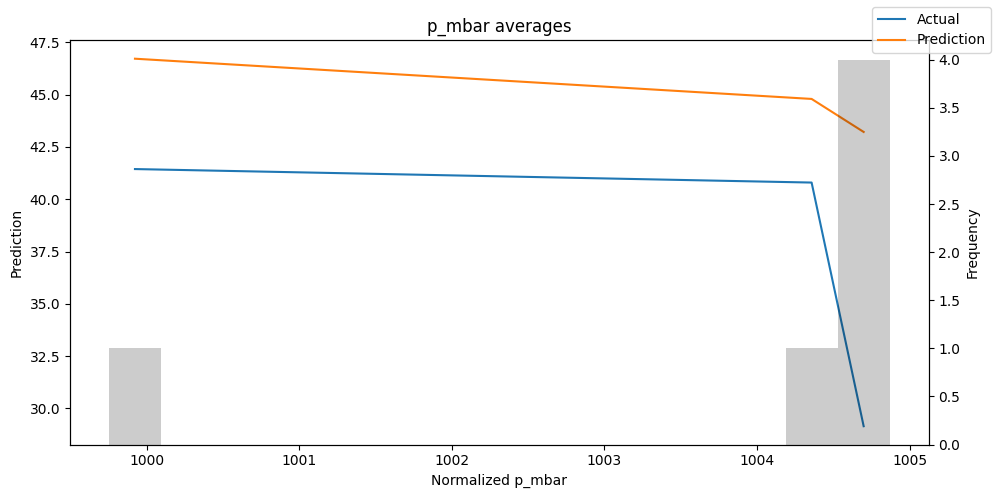

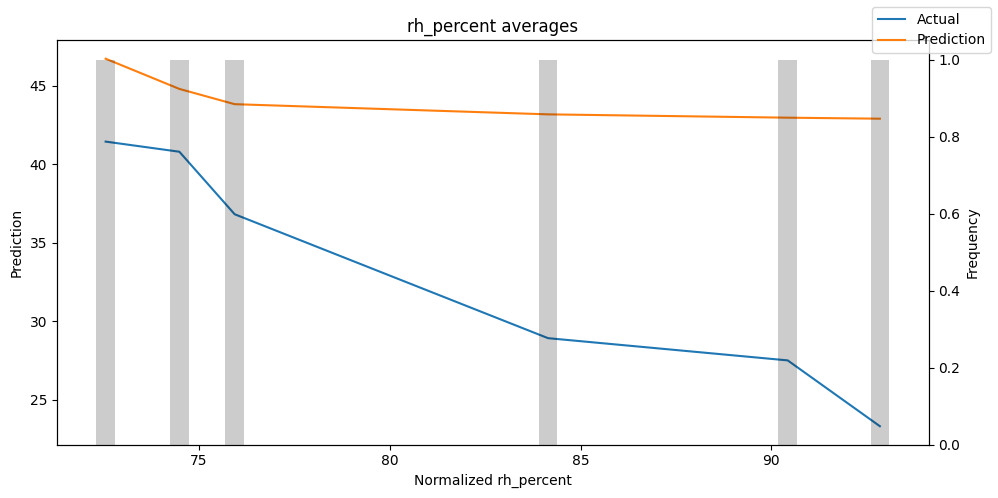

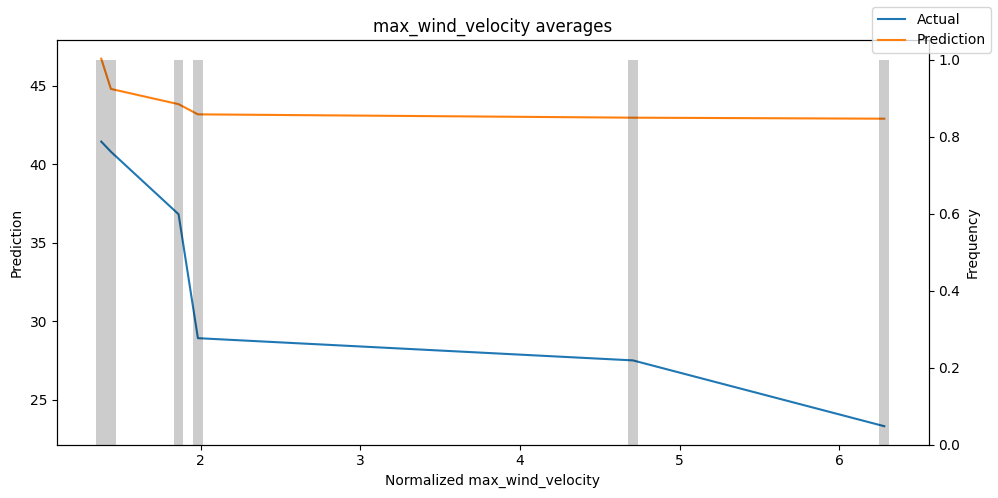

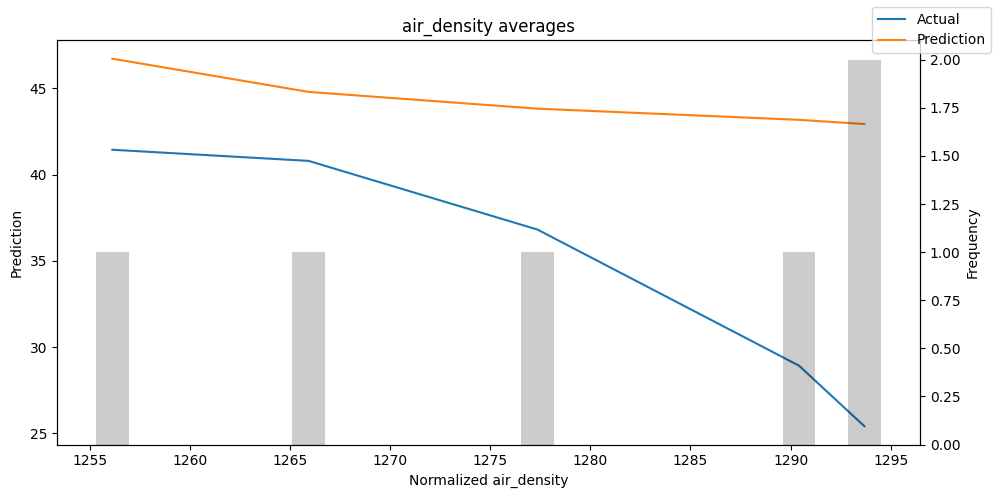

In [34]:
# Predictions vs. actuals by variable
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)